# Road segmentation

In this notebook, we'll be segmenting road networks from aerial imagery.

At the end, you will have trained a model to predict road segments over Port Vila.

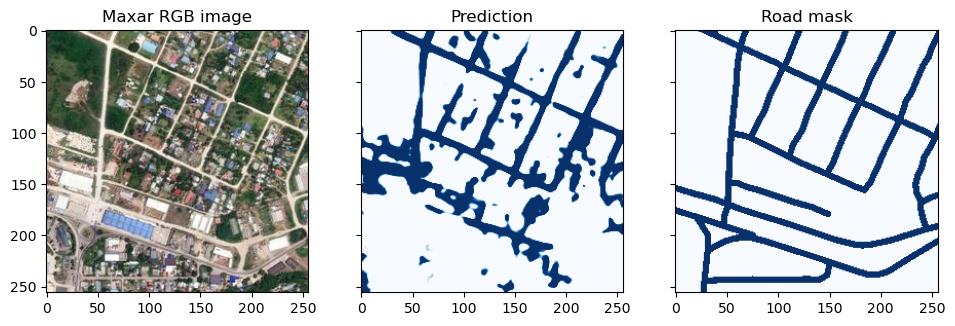

In [ ]:
!pip install -q torch xbatcher segmentation-models-pytorch

In [ ]:
import geocube.api.core
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import segmentation_models_pytorch as smp
import torch
import tqdm
import xarray as xr
import xbatcher.loaders.torch

## Data preprocessing

### Get image data from OpenAerialMap

- OpenAerialMap images over Vanuatu - https://map.openaerialmap.org/#/168.3819580078125,-16.688816956180833,7

We'll be using a Maxar Worldview-2 image with a spatial resolution of 32cm over Port Vila on 2024 October 19.

- Preview at https://map.openaerialmap.org/#/168.31419467926025,-17.73086527059167,14/square/311123113/676737799f511a0001cc98c1

In [ ]:
image_url = "https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/676733089f511a0001cc98b6/0/676733089f511a0001cc98b7.tif"

The RGB images are distributed in a Cloud-optimized GeoTIFF (COG) format.
We'll follow https://corteva.github.io/rioxarray/stable/examples/COG.html to open the file in Python.

**Note**: We set `overview_level=2` to get a lower resolution image.
The spatial resolutions at different overview levels are:
- Level -1 (native): 0.32 meters
- Level 0: 0.64 meters
- Level 1: 1.28 meters
- Level 2: 2.57 meters

In [ ]:
rda = rioxarray.open_rasterio(filename=image_url, overview_level=2)
rda

In [ ]:
# Check spatial resolution in meters
rda.rio.resolution()

In [ ]:
# Check coordinate reference system
rda.rio.crs.to_string()

In [ ]:
# Check bounding box extent
bbox = rda.rio.bounds()
bbox

The image in an `xarray.DataArray` can be plotted using `.plot.imshow(rgb="band")`

In [ ]:
rda.plot.imshow(rgb="band")

There are some black NoData/NaN areas, let's crop them out using
[`.rio.clip_box`](https://corteva.github.io/rioxarray/stable/examples/clip_box.html#Clip-using-a-bounding-box).

In [ ]:
rda_portvila = rda.rio.clip_box(
    minx=18732000, miny=-2012000, maxx=18742000, maxy=-2002000
)

In [ ]:
rda_portvila.plot.imshow(rgb="band")

In [ ]:
bbox_portvila = rda_portvila.rio.bounds()
bbox_portvila

### Load road linestrings from shapefile

Read from zipfile containing "Roads_Vanuatu_Cleaned_UNOSAT.shp"
into a [geopandas.GeoDataFrame](https://geopandas.org/en/v1.0.1/docs/reference/geodataframe.html).

In [ ]:
gdf_roads = gpd.read_file(filename="Roads_VUT.zip")
gdf_roads.head()

### Reproject vector roads to match aerial image

The vector road shapefile are in EPSG:4326,
and we will need to reproject it to EPSG:3857 to match the RGB image.

In [ ]:
gdf_roads_3857 = gdf_roads.to_crs(crs="EPSG:3857")

Next, we'll also clip the roads to the bounding box extent of the RGB image.

In [ ]:
gdf_roads_portvila = gdf_roads_3857.clip(mask=bbox_portvila)

Plot the clipped vector roads using
[`.plot()`](https://geopandas.org/en/v1.0.1/docs/reference/api/geopandas.GeoDataFrame.plot.html)

In [ ]:
gdf_roads_portvila.plot()

### Rasterize road lines

The vector road lines need to be converted into a raster format for the machine learning model.
We'll first buffer the road lines to become polygons, and then rasterize them using
[`geocube.api.core.make_geocube`](https://corteva.github.io/geocube/stable/geocube.html#make-geocube).

In [ ]:
# Assume all roads are 8 meters in width
gdf_roads_portvila.geometry = gdf_roads_portvila.buffer(distance=8)

In [ ]:
rds_roads = geocube.api.core.make_geocube(
    vector_data=gdf_roads_portvila,
    like=rda_portvila,
    measurements=["FID_Road_w"],
)

In [ ]:
# Convert to binary where 0=no_roads, 1=roads
rda_roads = rds_roads.FID_Road_w.notnull()

In [ ]:
rda_roads.plot.imshow()

### Stack RGB image and road mask together

We now have an RGB aerial image and rasterized Road map,
both in an `xarray.DataArray` format with the same
spatial resolution and bounding box spatial extent.
Let's stack them together using
[`xarray.merge`](https://docs.xarray.dev/en/v2025.03.1/generated/xarray.merge.html).

In [ ]:
ds_image_and_mask = xr.merge(
    objects=[rda_portvila.rename("image"), rda_roads.rename("mask")],
    join="override",
)
ds_image_and_mask

Double check to see that resulting xarray.Dataset’s image and mask looks ok.

In [ ]:
# Create subplot with RGB image on the left and Road mask on the right
fig, axs = plt.subplots(ncols=2, figsize=(11.5, 4.5), sharey=True)
ds_image_and_mask.image.plot.imshow(ax=axs[0], rgb="band")
axs[0].set_title("Maxar RGB image")
ds_image_and_mask.mask.plot.imshow(ax=axs[1], cmap="Blues")
axs[1].set_title("Road mask")
plt.show()

## Dataloader and Model architecture

Now let's set up our torch DataLoader and a UNet model!

### Create data chips with xbatcher

The entire image size (~3800x3800 pixels) is too large to fit in memory,
so let's create 256x256 pixel chips using a library called
[xbatcher](https://xbatcher.readthedocs.io) that will also help
us create a torch Dataset and DataLoader in a few lines of code.

References:
- https://xbatcher.readthedocs.io/en/latest/user-guide/training-a-neural-network-with-Pytorch-and-xbatcher.html#Step-2:-Create-batch-generator-and-data-loader

In [ ]:
# Define batch generators
X_bgen = xbatcher.BatchGenerator(
    ds_image_and_mask["image"], input_dims={"y": 256, "x": 256}
)
y_bgen = xbatcher.BatchGenerator(
    ds_image_and_mask["mask"], input_dims={"y": 256, "x": 256}
)

In [ ]:
# Map batches to a PyTorch-compatible dataset
dataset = xbatcher.loaders.torch.MapDataset(X_generator=X_bgen, y_generator=y_bgen)
# Create a dataloader
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32)

### UNet Model

For simplicity, we'll use a pre-designed model architecture from
https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet

In [ ]:
model = torch.hub.load(
    repo_or_dir="mateuszbuda/brain-segmentation-pytorch",
    model="unet",
    trust_repo=True,
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=True,
)
if torch.cuda.is_available():
    model = model.to(device="cuda")

In [ ]:
model

## Train the neural network

Now is the time to train the UNet model! We'll need to:
1. Choose a [loss function](https://pytorch.org/docs/2.6/nn.html#loss-functions) and
   [optimizer](https://pytorch.org/docs/2.6/optim.html). Here we're using a
   [DiceLoss](https://smp.readthedocs.io/en/latest/losses.html#diceloss) with the
   [Adam](https://pytorch.org/docs/2.6/generated/torch.optim.Adam.html) optimizer.
3. Configure training hyperparameters such as the learning rate (`lr`) and number of
   epochs (`max_epochs`) or iterations over the entire training dataset.
4. Construct the main training loop to:
   - get a mini-batch from the DataLoader
   - pass the mini-batch data into the model to get a prediction
   - minimize the error (or loss) between the prediction and groundtruth

Let's see how this is done!

In [ ]:
# Setup loss function and optimizer
loss_dice = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
# Main training loop
max_epochs: int = 10
size = len(dataloader.dataset)
for epoch in tqdm.tqdm(iterable=range(max_epochs)):
    for i, batch in enumerate(dataloader):
        # Split data into input (x) and target (y)
        image, mask = batch
        # assert image.shape == (2, 3, 128, 128), image.shape
        # assert mask.shape == (2, 128, 128), mask.shape
        assert image.device == torch.device("cpu")  # Data is on CPU

        # Move data to GPU if available
        if torch.cuda.is_available():
            image = image.to(device="cuda")  # Move data to GPU
            assert image.device == torch.device("cuda:0")  # Data is on GPU now!
            mask = mask.to(device="cuda")

        # Pass data into neural network model
        prediction = model(x=image.float())

        # Compute prediction error
        loss = loss_dice(
            y_pred=prediction.squeeze(dim=1), y_true=mask.to(dtype=torch.float32)
        )

        # Backpropagation (to minimize loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Report metrics
        current = (i + 1) * len(image)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Inference results

Besides monitoring the loss value, it is also good to calculate a metric like
Precision, Recall or F1-score. Let's first run the model in 'inference' mode to get
predictions.

In [ ]:
index = 21  # TODO change this to check a different image
image, mask = dataloader.dataset[index]
with torch.inference_mode():
    pred = model(x=image.unsqueeze(dim=0).to(device="cuda").float())
    pred = pred.cpu().squeeze(dim=(0, 1))

Now that we have the predicted road image, we can compute some metrics.

In [ ]:
# compute statistics for true positive, false positive, false negative and true negative "pixels"
tp, fp, fn, tn = smp.metrics.get_stats(
    output=pred, target=mask, mode="binary", threshold=0.5
)
f1_score = smp.metrics.f1_score(tp=tp, fp=fp, fn=fn, tn=tn, reduction="micro")
precision = smp.metrics.precision(
    tp=tp, fp=fp, fn=fn, tn=tn, reduction="micro-imagewise"
)
recall = smp.metrics.recall(tp=tp, fp=fp, fn=fn, tn=tn, reduction="micro-imagewise")
print(f"F1 Score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Finally, let's compare the model predicted road to the 'groundtruth' road mask
by visualizing it side by side as below.

In [ ]:
# Create subplot with RGB image on the left, prediction in middle, and Road mask on the right
fig, axs = plt.subplots(ncols=3, figsize=(11.5, 4.5), sharey=True)
axs[0].imshow(image.permute(1, 2, 0))
axs[0].set_title("Maxar RGB image")
axs[1].imshow(pred, cmap="Blues", vmin=0, vmax=1)
axs[1].set_title("Prediction")
axs[2].imshow(mask, cmap="Blues")
axs[2].set_title("Road mask")
plt.show()